In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [87]:
for i in pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv").columns:
    print(i)

date
World
Afghanistan
Albania
Algeria
Andorra
Angola
Anguilla
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bonaire Sint Eustatius and Saba
Bosnia and Herzegovina
Botswana
Brazil
British Virgin Islands
Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Cayman Islands
Central African Republic
Chad
Chile
China
Colombia
Congo
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Democratic Republic of Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Faeroe Islands
Falkland Islands
Fiji
Finland
France
French Polynesia
Gabon
Gambia
Georgia
Germany
Ghana
Gibraltar
Greece
Greenland
Grenada
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
International
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kaz

In [93]:
class CountryStatus:
        
    def __init__(self, country):
        self.country = country
        
        try:
            self.World_cases = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv")
            self.World_deaths = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_deaths.csv")
        except Exception as e:
            print("Data could not be fetched")
            print(e)
            return None
        
        def _cleaning_and_getting_country_data(df):
            if self.country in list(df.columns):
                df = _clean_process(df)
                return df
            else:
                print("Please Select an available Country")

        def _clean_process(df):        
            df = df[['date',self.country]]
            df = df[True != df[self.country].isna()]
            df = df.drop_duplicates([self.country])
            df = df[df[self.country] > 0]
            return df
        
        self.data_cases = _cleaning_and_getting_country_data(df = self.World_cases)
        self.data_deaths = _cleaning_and_getting_country_data(df = self.World_deaths)
        self.last_update = list(self.data_cases['date'])[-1]
        self.logistic_params_cases = []
        self.logistic_params_error_cases = []
        self.logistic_params_deaths = []
        self.logistic_params_error_deaths = []
        self.exp_params_cases = []
        self.exp_params_deaths = []
        self.last_day_of_infection = None
        self._solution = None
        self.logistic_model = lambda x,a,b,c: c/(1+np.exp(-(x-b)/a))
        self.exponential_model = lambda x,a,b,c: a*np.exp(b*(x-c))
    
    
    def prediction(self, plot= True, cases = True, p0_log = [5,20,40000], p0_exp = [0.5,0.5,0.5]):
         
        if cases:
            df = self.data_cases.copy()
        else:
            df = self.data_deaths.copy()
        
        if len(self.logistic_params_cases) == 0 or len(self.logistic_params_error_deaths) == 0:
            df['date'] = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - datetime.strptime("2020-01-01", '%Y-%m-%d')).days)
            x = list(df.iloc[:,0])
            y = list(df.iloc[:,1])

            try:
                fit = curve_fit(self.logistic_model,x,y,p0=p0_log, maxfev=2000)
            except Exception as e:
                print("To get a result, please change the parameters in the list p0_log")
                print(e)
                return None
            errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
            a,b,c = fit[0]
            if cases:
                self.logistic_params_error_cases = errors
                self.logistic_params_cases = fit[0]
            else:
                self.logistic_params_error_deaths = errors
                self.logistic_params_deaths = fit[0]

            try:  
                exp_fit = curve_fit(self.exponential_model,x,y,p0=p0_exp)
            except Exception as e:
                print("To get a results, please change the parameters in the list p0_exp")
                print(e)
                return None
            if cases:
                self.exp_params_cases = exp_fit[0]
                
                solution = int(fsolve(lambda x : self.logistic_model(x,a,b,c) - int(c),b))
                first_day = datetime.strptime("2020-01-01", '%Y-%m-%d')
                last_day = first_day + timedelta(days=solution)
                last_day = datetime.strftime(last_day,'%Y-%m-%d')
                self.last_day_of_infection = last_day
                self._solution = solution
            else:
                self.exp_params_deaths = exp_fit[0]

            
            
        if cases:
            print("Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): ")
            print("a = ", self.logistic_params_cases[0], " +/- ", self.logistic_params_error_cases[0])
            print("b = ", self.logistic_params_cases[1], " +/- ", self.logistic_params_error_cases[1])
            print("c = ", self.logistic_params_cases[2], " +/- ", self.logistic_params_error_cases[2] , "(This also means the amount of cases at the end.)" )
            print("Last day of infections : ", self.last_day_of_infection , " (approximately)")
            
        else:
            print("Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): ")
            print(self.logistic_params_deaths)
            print("a = ", self.logistic_params_deaths[0], " +/- ", self.logistic_params_error_deaths[0])
            print("b = ", self.logistic_params_deaths[1], " +/- ", self.logistic_params_error_deaths[1])
            print("c = ", self.logistic_params_deaths[2], " +/- ", self.logistic_params_error_deaths[2])
        
        
        if plot:
            
            if df['date'].dtype == self.data_cases['date'].dtype:
                df['date'] = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - datetime.strptime("2020-01-01", '%Y-%m-%d')).days)
            x = list(df.iloc[:,0])
            y = list(df.iloc[:,1])
            pred_x = list(range(max(x),self._solution))
            plt.rcParams['figure.figsize'] = [7, 7]
            plt.rc('font', size=14)
            
            if cases:
                a_log_mod,b_log_mod,c_log_mod = self.logistic_params_cases
                a_exp, b_exp, c_exp = self.exp_params_cases
                
            else:
                a_log_mod,b_log_mod,c_log_mod = self.logistic_params_deaths
                a_exp, b_exp, c_exp = self.exp_params_deaths
            # Actual DATA
            plt.scatter(df.iloc[:,0], df.iloc[:,1],label="Actual data", color="#2554C7")
            # Predicted DATA with logistic model
            plt.plot(x+pred_x, [self.logistic_model(i,a_log_mod,b_log_mod,c_log_mod) for i in x+pred_x], label="Logistic curve", alpha = 0.7, color="green")
            # Predicted DATA with exponential model
            plt.plot(x+pred_x, [self.exponential_model(i,a_exp, b_exp, c_exp) for i in x+pred_x], label="Exponential curve",alpha=0.6, color = "red")
            plt.legend()
            plt.xlabel("Days from 1 January 2020")
            if cases:
                plt.ylabel("Amount of infected people")
                plt.ylim((min(y)*0.9,c_log_mod*1.1))

            else:
                plt.ylabel("Amount of deaths")  
                plt.ylim((min(y)*0.9,c_log_mod*1.1))

            plt.show()
            return None
               
                   
    def derivative(self, cases = True):
        plt.rcParams['figure.figsize'] = [7, 7]
        plt.rc('font', size=14)
        
        if cases:
            df = self.data_cases.copy()
        else:
            df = self.data_deaths.copy()
        print("Last updating of data :",self.last_update)
       
        df['date'] = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - datetime.strptime("2020-01-01", '%Y-%m-%d')).days)
        x = list(df.iloc[:,0])
        y = list(df.iloc[:,1])

        derivative = []
        for i in range(len(x)):
            if i == 0:
                pass
            else:
                derivative.append((df.iloc[i,1]-df.iloc[i-1,1])/(df.iloc[i,0]-df.iloc[i-1,0]))
        plt.plot(x[1:],derivative)
        plt.xlabel("Days from 1 January 2020")
        plt.ylabel("Cases per unit of time")
        
        return None
    
    def ploting(self):
        plt.rcParams['figure.figsize'] = [7, 7]
        plt.rc('font', size=14)
        
        print("Last updating of data :",self.last_update)
        df = self.data_cases.copy()
        df['date'] = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - datetime.strptime("2020-01-01", '%Y-%m-%d')).days)
        plt.plot(df.iloc[:,0], df.iloc[:,1],label="Real data",color="red", linestyle = 'dashed')
        plt.xlabel("Days from 1 January 2020")
        
        return None

In [94]:
US = CountryStatus("United States")

Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): 
a =  4.230195281469592  +/-  0.09067875181594968
b =  92.7581678688556  +/-  0.31554553974422794
c =  486361.7077532945  +/-  17546.297980165855 (This also means the amount of cases at the end.)
Last day of infections :  2020-05-29  (approximately)


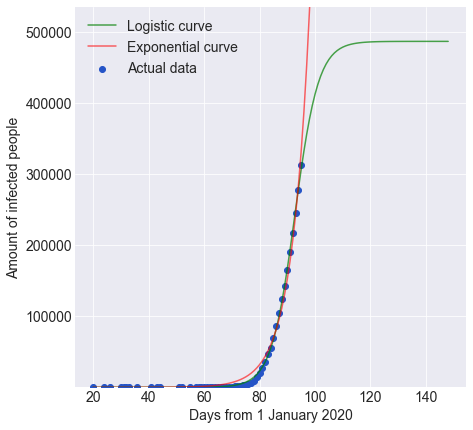

In [95]:
US.prediction()